# ParameterWithSetpoints with setpoints defined on another instrument.

This notebook provides an example for writing a ParameterWithSetpoints that 
gets it setpoints from a different instrument. 
This is meant as an extension [Simple Example of ParameterWithSetpoints](Simple-Example-of-ParameterWithSetpoints.ipynb) which you should read before reading this notebook. 

This is meant for the situation where an instrument has the capability to capture data into a buffer. This could be either by measuring a time series or by capturing each datapoint in the buffer via an external trigger. Such an instrument could capture the data into a ParameterWithSetpoints that user the time or the index of the buffer as setpoints. However, this is typically not very useful as the setpoints that are relevant for your experiment are often set by another instrument that is being swept as you read data into the buffer of the first instrument. This notebook shows an example of how you can generate the setpoints from the sweep settings of another instrument.



In [1]:
import numpy as np
import os

In [2]:
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/vsts/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/vsts/.qcodes/logs/201118-17140-qcodes.log


In [3]:
from qcodes.dataset.sqlite.database import initialise_or_create_database_at
from qcodes.dataset.experiment_container import load_or_create_experiment

In [4]:
from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter, DelegateParameter

First, we define a dummy instrument that returns something like a current measurement buffer starting from a DelegateParameter given by `sweep_start` to one given by `sweep_stop` in `n_points` steps. 

A function is added that allows you to set the parameters that `sweep_start` and `sweep_stop` delegates to.

In [5]:
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """
    def __init__(self, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(self._startparam(), self._stopparam(),
                              self._numpointsparam())


    
class DummyArray(ParameterWithSetpoints):
    
    def get_raw(self):
        npoints = self.root_instrument.sweep_n_points.get_latest()
        return np.random.rand(npoints)
    

class DummyBufferedDMM(Instrument):
    
    def __init__(self, name, **kwargs):
        
        super().__init__(name, **kwargs)
            

        self.add_parameter('sweep_start',
                           source=None,
                           parameter_class=DelegateParameter)

        self.add_parameter('sweep_stop',
                           source=None,
                           parameter_class=DelegateParameter)

        self.add_parameter('sweep_n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('setpoints',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.sweep_start,
                           stopparam=self.sweep_stop,
                           numpointsparam=self.sweep_n_points,
                           vals=Arrays(shape=(self.sweep_n_points.get_latest,)))
                           
        self.add_parameter('current',
                           get_cmd=self._get_current_data,
                           unit='A',
                           setpoints=(self.setpoints,),
                           label='Current',
                           parameter_class=ParameterWithSetpoints,
                           vals=Arrays(shape=(self.sweep_n_points.get_latest,)))

    def _get_current_data(self):
        npoints = self.sweep_n_points.get_latest()
        return np.random.rand(npoints)

    def set_sweep_parameters(self, start_parameter, stop_parameter, label=None):
        if start_parameter.unit != stop_parameter.unit:
            raise TypeError("You must sweep from and to "
                            "parameters with the same unit")
        self.sweep_start.source = start_parameter
        self.sweep_stop.source = stop_parameter
        self.setpoints.unit = start_parameter.unit
        if label != None:
            self.setpoints.label = label


class DummyWaveformGenerator(Instrument):
    
    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)

        self.add_parameter('v_start',
                           initial_value=0,
                           unit='V',
                           label='v start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('v_stop',
                           initial_value=1,
                           unit='V',
                           label='v stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)



In [6]:
tutorial_db_path = os.path.join(os.getcwd(), 'tutorial_paramter_with_setpoints.db')
initialise_or_create_database_at(tutorial_db_path)
load_or_create_experiment(experiment_name='tutorial_ParameterWithSetpoints', sample_name="no sample")

0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]

Upgrading database; v0 -> v1: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v1 -> v2: 100%|██████████| 1/1 [00:00<00:00, 481.77it/s]


0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]

Upgrading database; v2 -> v3: : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]

Upgrading database; v3 -> v4: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v4 -> v5: 100%|██████████| 1/1 [00:00<00:00, 1187.18it/s]


0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]

Upgrading database; v5 -> v6: : 0it [00:00, ?it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v6 -> v7: 100%|██████████| 1/1 [00:00<00:00, 443.04it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v7 -> v8: 100%|██████████| 1/1 [00:00<00:00, 1090.56it/s]


  0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9:   0%|          | 0/1 [00:00<?, ?it/s]

Upgrading database; v8 -> v9: 100%|██████████| 1/1 [00:00<00:00, 819.52it/s]

tutorial_ParameterWithSetpoints#no sample#1@/home/vsts/work/1/s/docs/examples/Parameters/tutorial_paramter_with_setpoints.db
----------------------------------------------------------------------------------------------------------------------------

In [7]:
dmm = DummyBufferedDMM('dmm')
wg = DummyWaveformGenerator('wg')

First, we assume that we have wired up our instruments such that the current buffer will 
correspond to a voltage sweep from `v_start` to `v_stop`

For a real world experiment this would probably be wired such that the DMM is triggered at the start of the voltage sweep and then automatically measures `sweep_n_points` in the time that it takes the waveform generator to sweep to `v_stop`


In [8]:
dmm.set_sweep_parameters(wg.v_start, wg.v_stop, label="Voltage")

In [9]:
wg.v_start(0)
wg.v_stop(1)
dmm.sweep_n_points(501)

And we can grab the setpoints axis

In [10]:
dmm.sweep_n_points()

501

In [11]:
sp_axis = dmm.setpoints()
len(sp_axis)

501

In [12]:
sp_axis[:10]

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018])

As expected we get a result wit 501 points as we asked for an axis with 501 points. 

In [13]:
dmm.setpoints.validate(dmm.setpoints.get())

Naturally, we can also get the current buffer.

In [14]:
current = dmm.current.get()
len(current)

501

When we validate a `ParameterWithSetpoints`, we automatically validate that the shape is consistent between the parameters and its setpoints. As well as validating the shape as above.

In [15]:
dmm.current.validate(dmm.current.get())

The consistent shapes can be validated explicitly.

In [16]:
dmm.current.validate_consistent_shape()

We can inspect the setpoints of the spectrum.

In [17]:
dmm.current.setpoints

(<__main__.GeneratedSetPoints: setpoints at 139794011978704>,)

## Measurement

Starting experimental run with id: 1. 


([<AxesSubplot:title={'center':'Run #1, Experiment tutorial_ParameterWithSetpoints (no sample)'}, xlabel='Voltage (V)', ylabel='Current (mA)'>],
 [None])

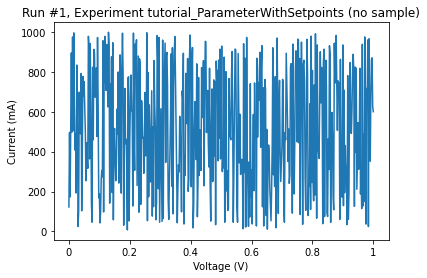

In [18]:
meas = Measurement()
meas.register_parameter(dmm.current)

with meas.run() as datasaver:
    datasaver.add_result((dmm.current, dmm.current()))
    
    dataid = datasaver.run_id
plot_dataset(datasaver.dataset)

In [19]:
wg.v_stop(10)

Starting experimental run with id: 2. 


([<AxesSubplot:title={'center':'Run #2, Experiment tutorial_ParameterWithSetpoints (no sample)'}, xlabel='Voltage (V)', ylabel='Current (mA)'>],
 [None])

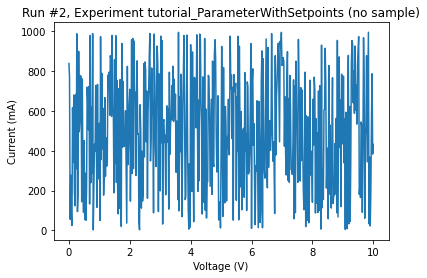

In [20]:
meas = Measurement()
meas.register_parameter(dmm.current)

with meas.run() as datasaver:
    datasaver.add_result((dmm.current, dmm.current()))
    
    dataid = datasaver.run_id
plot_dataset(datasaver.dataset)

Now imagine that we change our wiring such that we are sweeping a magnetic field while samling the current.

In [21]:
class DummyMagnetPS(Instrument):
    """
    We assume this is a powersupply for an magnet that allows
    you to set the magnetic field.
    """
    
    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)

        self.add_parameter('b_start',
                           initial_value=0,
                           unit='T',
                           label='B start',
                           vals=Numbers(0,7),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('b_stop',
                           initial_value=1,
                           unit='T',
                           label='b stop',
                           vals=Numbers(0,7),
                           get_cmd=None,
                           set_cmd=None)

In [22]:
mpsu = DummyMagnetPS(name='psu1')

In [23]:
dmm.set_sweep_parameters(mpsu.b_start, mpsu.b_stop, label="Magnetic field")

Starting experimental run with id: 3. 


([<AxesSubplot:title={'center':'Run #3, Experiment tutorial_ParameterWithSetpoints (no sample)'}, xlabel='Magnetic field (T)', ylabel='Current (mA)'>],
 [None])

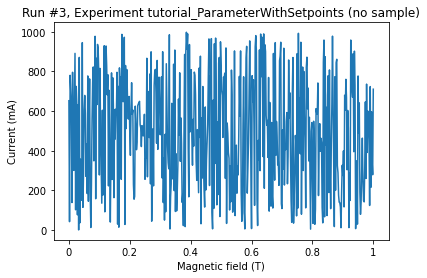

In [24]:
meas = Measurement()
meas.register_parameter(dmm.current)

with meas.run() as datasaver:
    datasaver.add_result((dmm.current, dmm.current()))
    
    dataid = datasaver.run_id
plot_dataset(datasaver.dataset)